In [1]:
import neuralfoil as nf  # `pip install neuralfoil`
import numpy as np
import matplotlib.pyplot as plt  # `pip install matplotlib`
import matplotlib.cm as cm  # Colormap module
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from aerosandbox.geometry.airfoil.airfoil_families import get_kulfan_parameters
import aerosandbox as asb

In [52]:
# Set parameters
Re = 5e6
alphas_nf = np.linspace(-60, 60, 600)
airfoil = asb.Airfoil("naca0014")
models = ["xxsmall", "xsmall", "small", "medium", "large", "xlarge", "xxlarge", "xxxlarge"]

# Choose a group of airfoils
thickness_airfoils = ["naca0012", "naca0015", "naca0018", "naca0021"]
camber_airfoils = ["naca0012", "naca2412", "naca4412"]

In [21]:
# Global colormap data
cmap = cm.viridis #winter #inferno
norm = plt.Normalize(0, len(models) - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

In [42]:
# Get Kulfan parameters example
kulfan_params = get_kulfan_parameters(
    airfoil.coordinates,
    n_weights_per_side=8
)

print(kulfan_params)

lower_weights = kulfan_params["lower_weights"] #[] # sample array
upper_weights = kulfan_params["upper_weights"] #[] # sample array
leading_edge_weight = kulfan_params["leading_edge_weight"] # sample value
TE_thickness = kulfan_params["TE_thickness"] # sample value

print("Lower weights: ", lower_weights)

# Create kulfan_params
kulfan_params = {
    "lower_weights": lower_weights,
    "upper_weights": upper_weights,
    "leading_edge_weight": leading_edge_weight,
    "TE_thickness": TE_thickness
}


{'lower_weights': array([-0.20169847, -0.1768234 , -0.20272357, -0.14896092, -0.19228821,
       -0.14743867, -0.17021421, -0.16239955]), 'upper_weights': array([0.20169847, 0.1768234 , 0.20272357, 0.14896092, 0.19228821,
       0.14743867, 0.17021421, 0.16239955]), 'TE_thickness': 0.0029725496888779734, 'leading_edge_weight': -3.804419138626366e-16}
Lower weights:  [-0.20169847 -0.1768234  -0.20272357 -0.14896092 -0.19228821 -0.14743867
 -0.17021421 -0.16239955]


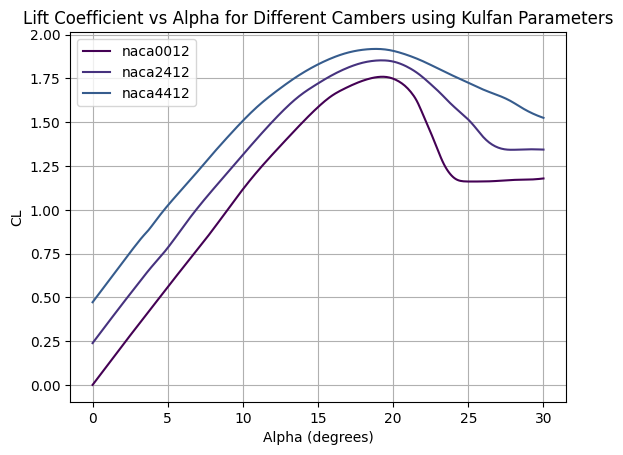

In [44]:
## Use airfoil names to get Kulfan parameters for various cambered airfoils

# Create a figure and an axis
fig, ax = plt.subplots()

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(camber_airfoils):
    airfoil = asb.Airfoil(airfoil_name)

    # Get kulfan parameters
    kulfan_params = get_kulfan_parameters(
    airfoil.coordinates,
    n_weights_per_side=8
    )

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )
    ax.plot(alphas_nf, aero["CL"], label=airfoil_name, color=cmap(norm(idx)))

# Add labels, title, and colorbar
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CL")
ax.set_title("Lift Coefficient vs Alpha for Different Cambers using Kulfan Parameters")
ax.legend()
ax.grid(True)

c:\Users\wongj_rl8z6\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralfoil\gen2_5_architecture\main.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


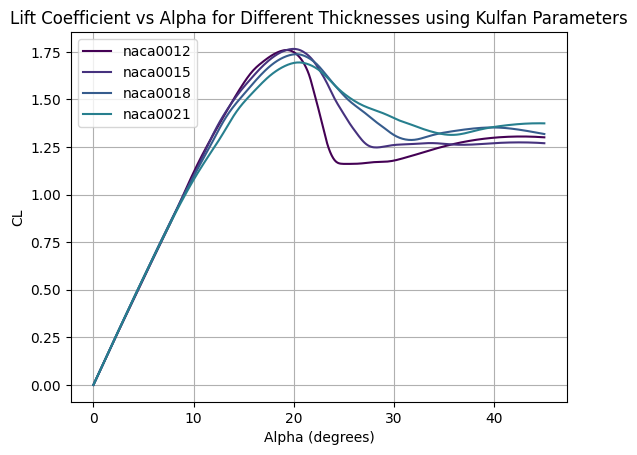

In [ ]:
## Use airfoil names to get Kulfan parameters for various thicknesses of airfoils

# Create a figure and an axis
fig, ax = plt.subplots()

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(thickness_airfoils):
    airfoil = asb.Airfoil(airfoil_name)

    # Get kulfan parameters
    kulfan_params = get_kulfan_parameters(
    airfoil.coordinates,
    n_weights_per_side=8
    )

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )
    ax.plot(alphas_nf, aero["CL"], label=airfoil_name, color=cmap(norm(idx)))

# Add labels, title, and colorbar
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CL")
ax.set_title("Lift Coefficient vs Alpha for Different Thicknesses using Kulfan Parameters")
ax.legend()
ax.grid(True)

In [36]:
### Try creating a kulfan parameters bank

# Define the Kulfan Parameters class
class KulfanParameters:
    def __init__(self):
        self.lower_weights = None
        self.upper_weights = None
        self.leading_edge_weight = None
        self.TE_thickness = None

    def set_parameters(self, lower_weights, upper_weights, leading_edge_weight, TE_thickness):
        self.lower_weights = lower_weights
        self.upper_weights = upper_weights
        self.leading_edge_weight = leading_edge_weight
        self.TE_thickness = TE_thickness

    def to_dict(self):
        return {
            "lower_weights": self.lower_weights,
            "upper_weights": self.upper_weights,
            "leading_edge_weight": self.leading_edge_weight,
            "TE_thickness": self.TE_thickness,
        }

# Define the Kulfan Parameters Bank class
class KulfanParametersBank:
    def __init__(self):
        self.bank = {}

    def add_airfoil(self, name, lower_weights, upper_weights, leading_edge_weight, TE_thickness):
        kf = KulfanParameters()
        kf.set_parameters(lower_weights, upper_weights, leading_edge_weight, TE_thickness)
        self.bank[name] = kf.to_dict()

    def get_airfoil(self, name):
        return self.bank.get(name, None)

    def list_airfoils(self):
        return list(self.bank.keys())

    def display_bank(self):
        for name, params in self.bank.items():
            print(f'Name: "{name}"')
            for key, value in params.items():
                print(f'  {key}: {value}')
            print()

    # Create a function to take in an airfoil name and return the Kulfan parameters
    def add_airfoil_by_name(self, airfoil_name):
            airfoil = asb.Airfoil(airfoil_name)
            params = get_kulfan_parameters(airfoil.coordinates, n_weights_per_side=8)
            self.add_airfoil(airfoil_name, **params)


In [46]:
# Example usage
kulfan_bank = KulfanParametersBank()

# # Add airfoils to the bank
# kulfan_bank.add_airfoil(
#     name="NACA0012",
#     lower_weights=[0.1, 0.2, 0.3],
#     upper_weights=[0.1, 0.2, 0.3],
#     leading_edge_weight=0.01,
#     TE_thickness=0.02
# )

# kulfan_bank.add_airfoil(
#     name="NACA2412",
#     lower_weights=[0.15, 0.25, 0.35],
#     upper_weights=[0.15, 0.25, 0.35],
#     leading_edge_weight=0.02,
#     TE_thickness=0.03
# )

# kulfan_bank.add_airfoil_by_name("naca0012")
for airfoil_name in thickness_airfoils:
    kulfan_bank.add_airfoil_by_name(airfoil_name)

kulfan_bank.add_airfoil(
    name="naca0013.5",
    lower_weights=[-0.19449495, -0.17050829, -0.19548344, -0.14364089, -0.18542077, -0.14217300, -0.16413513, -0.15659957], 
    upper_weights=[0.19449495, 0.17050829, 0.19548344, 0.14364089, 0.18542077, 0.14217300, 0.16413513, 0.15659957], 
    leading_edge_weight=-3.4273922475165367e-16, 
    TE_thickness=0.0028663872000144446, 
)
# Retrieve an airfoil's parameters
# naca0012_params = kulfan_bank.get_airfoil("naca0012")
# print("naca0012 Parameters:", naca0012_params)

# List all airfoils in the bank
airfoil_list = kulfan_bank.list_airfoils()
print("Airfoils in the bank:", airfoil_list)

# Display the entire bank
kulfan_bank.display_bank()

Airfoils in the bank: ['naca0012', 'naca0015', 'naca0018', 'naca0021', 'naca0013.5']
Name: "naca0012"
  lower_weights: [-0.1728844  -0.15156292 -0.17376306 -0.12768079 -0.16481846 -0.126376
 -0.14589789 -0.13919961]
  upper_weights: [0.1728844  0.15156292 0.17376306 0.12768079 0.16481846 0.126376
 0.14589789 0.13919961]
  leading_edge_weight: -4.087778939030135e-16
  TE_thickness: 0.0025478997333239634

Name: "naca0015"
  lower_weights: [-0.2161055  -0.18945365 -0.21720382 -0.15960099 -0.20602308 -0.15797
 -0.18237237 -0.17399952]
  upper_weights: [0.2161055  0.18945365 0.21720382 0.15960099 0.20602308 0.15797
 0.18237237 0.17399952]
  leading_edge_weight: -2.7670055560029385e-16
  TE_thickness: 0.00318487466665493

Name: "naca0018"
  lower_weights: [-0.2593266  -0.22734438 -0.26064458 -0.19152119 -0.2472277  -0.18956401
 -0.21884684 -0.20879942]
  upper_weights: [0.2593266  0.22734438 0.26064458 0.19152119 0.2472277  0.18956401
 0.21884684 0.20879942]
  leading_edge_weight: -3.5984111

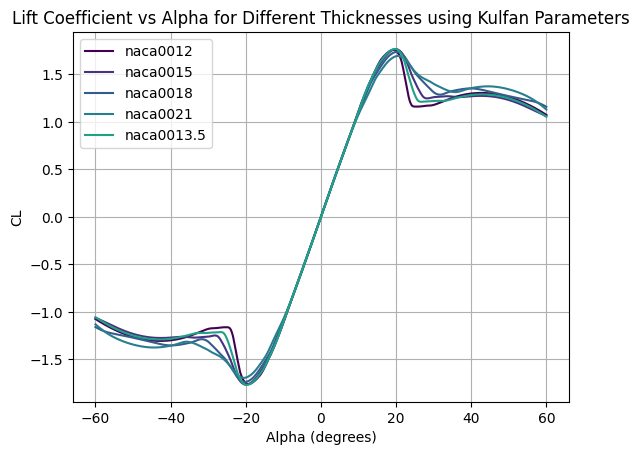

In [53]:
# Plot the lift for the airfoils in the bank

# Create a figure and an axis
fig, ax = plt.subplots()

# Get the list of all airfoil names in the bank
airfoil_names = kulfan_bank.list_airfoils()

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(airfoil_names):

    # Get kulfan parameters
    kulfan_params = kulfan_bank.get_airfoil(airfoil_name)

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )
    ax.plot(alphas_nf, aero["CL"], label=airfoil_name, color=cmap(norm(idx)))

# Add labels, title, and colorbar
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CL")
ax.set_title("Lift Coefficient vs Alpha for Different Thicknesses using Kulfan Parameters")
ax.legend()
ax.grid(True)

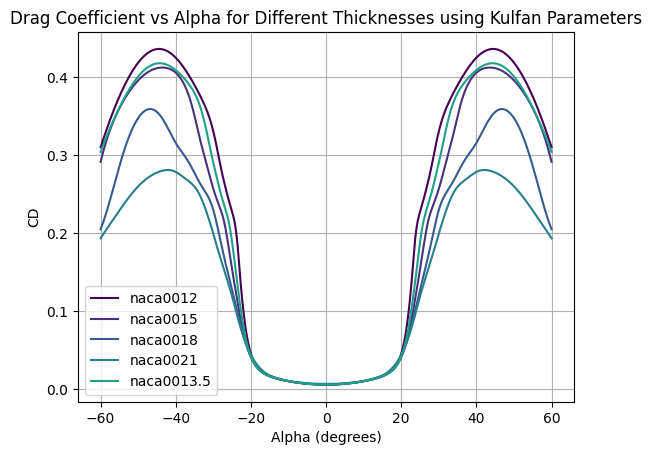

In [54]:
# Plot the drag for the airfoils in the bank

# Create a figure and an axis
fig, ax = plt.subplots()

# Get the list of all airfoil names in the bank
airfoil_names = kulfan_bank.list_airfoils()

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(airfoil_names):

    # Get kulfan parameters
    kulfan_params = kulfan_bank.get_airfoil(airfoil_name)

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )
    ax.plot(alphas_nf, aero["CD"], label=airfoil_name, color=cmap(norm(idx)))

# Add labels, title, and colorbar
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CD")
ax.set_title("Drag Coefficient vs Alpha for Different Thicknesses using Kulfan Parameters")
ax.legend()
ax.grid(True)